<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/dashboard_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Install requirements and prepare the dataset for training.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_ROOT = "/content/drive/MyDrive/data/Top15/train_top15_a_seatbelt/"

In [3]:
import glob
import os

def glob_files(path, file_type="*"):
    search_string = os.path.join(path, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths


In [4]:
import cv2
import numpy as np

IMAGE_SIZE = 600

def load_images(path):
  files = glob_files(path, "*.jpg")

  # print(files)
  X_data = []
  for file in files:
    image = cv2.imread(file)
    image = image/255
    # print(image.shape)
    # x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

    X_data.append(image)
  return np.array(X_data)

In [5]:
X = load_images(DATA_ROOT + "train_top15_a_seatbelt_0/")
X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(90,)

In [6]:
# WIDTH = 1920
# HEIGHT = 1080

def load_labels(path, X):
  files = glob_files(path, "*.txt")

  Y_data = []
  for file, x in zip(files, X):
    width = x.shape[1]
    height = x.shape[0]
    with open(file) as f:
      lines = f.readlines()

      boxes = []
      for line in lines:
        tokens = line.split()

        class_id = int(tokens[0])
        xc = float(tokens[1]) * width
        yc = float(tokens[2]) * height
        box_width = float(tokens[3]) * width
        box_height = float(tokens[4]) * height

        boxes.append(np.array([class_id, xc, yc, box_width, box_height]))
        # print(class_id, xc, yc, width, height)

      Y_data.append(np.array(boxes))
      # print(lines)
  return np.array(Y_data)

Y = load_labels(DATA_ROOT + "train_top15_a_seatbelt_0/", X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [51]:
COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

CLASS_NAMES = ["alert@Alternator", "alert@Brake", "alert@Coolant",
        "alert@Distance", "alert@EngineOil", "alert@EngineOilTemp",
        "alert@Parking", "alert@Retaining", "alert@Seatbelt",
        "alert@Steering",

        "warning@ABS", "warning@Brake", "warning@BrakeWear",
        "warning@CentralMonitoring", "warning@EPC", "warning@Engine",
        "warning@Fuel", "warning@Glow", "warning@Headlamp",
        "warning@Lamp", "warning@Parking", "warning@Retaining",
        "warning@StabilityOff", "warning@StabilityOn", "warning@Steering",
        "warning@TPMS", "warning@Tire", "warning@Washer"]

TOPS = [
    # Top 5
    "alert@Seatbelt",
    "warning@Engine",
    "alert@Parking",
    "warning@Tire",
    "warning@StabilityOn",

    # Top 10
    "alert@Brake",
    "warning@StabilityOff",
    "warning@Brake",
    "alert@Steering",
    "warning@Parking",

    # Top 15
    "alert@Retaining",
    "alert@Distance",
    "warning@ABS",
    "alert@Coolant",
    "warning@Fuel"
]

TOP5 = TOPS[:5]
TOP10 = TOPS[5:10]
TOP15 = TOPS[10:15]

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_patch_rectangle(y, color=COLORS[2]):
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

def plot_image(image, boxes, axis):
  # print(boxes.shape)
  for box in boxes:
    # print(box)
    class_id = int(box[0])
    # print(type(class_id), class_id)
    rect = create_patch_rectangle(box[1:])
    axis.add_patch(rect)

  plt.imshow(image)

def plot_images(X, Y, limit=10):
  fig = plt.figure(figsize=(100, 80))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plot_image(X[id], Y[id], axis)

def plot_label_images(X, Y, limit=10):
  fig = plt.figure(figsize=(10, 8))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.set_title(CLASS_NAMES[Y[id]])
    axis.imshow(X[id])
  fig.show()

def get_bbox(y):
  width = int(y[2])
  height = int(y[3])
  return int(y[0] - width/2), int(y[1] - height/2), width, height

def plot_labels(X, Y, limit=30):
  fig = plt.figure(figsize=(10, 8))
  last_id = min(limit, X.shape[0])

  print(last_id, limit, X.shape[0])

  label_id = 1
  for id in range(last_id):

    image = X[id]
    for box in Y[id]:
      if label_id >= 100:
        break

      class_id = int(box[0])
      x, y, box_width, box_height = get_bbox(box[1:])
      # print("y:", y, y + box_height, "x:", x, x + box_width)
      # print(image[y:y+box_height, x:x+box_width].shape)

      axis = fig.add_subplot(10, 10, label_id)
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(image[y:y+box_height, x:x+box_width])

      axis.show()
      label_id += 1

LABEL_SIZE = 20
def extract_box_image_data(X, Y):
  box_images = []
  box_labels = []
  for id in range(len(X)):
    image = X[id]
    for box in Y[id]:
      class_id = int(box[0])
      box_labels.append(class_id)

      x, y, box_width, box_height = get_bbox(box[1:])
      box_image = image[y:y+box_height, x:x+box_width]
      # Make sure that you resize all labels.
      # This is necessary for two reasons:
      #   1. If image sizes are different,
      #      the resulting box_images will not be a whole sum np.array.
      #     Instead, it will become an array of arraies
      #   2. For clustering purposes
      box_image = cv2.resize(box_image, (IMAGE_SIZE, IMAGE_SIZE))
      box_images.append(box_image)

  box_images = np.array(box_images)
  box_labels = np.array(box_labels)
  return box_images, box_labels
# plot_images(np.array(X[:1]), np.array(Y[:1]))

In [12]:
# plot_labels(np.array(X[:50]), np.array(Y[:50]), limit=50)

box_images, box_labels = extract_box_image_data(X, Y)

In [13]:
box_labels.shape
box_images.shape

(623, 600, 600, 3)

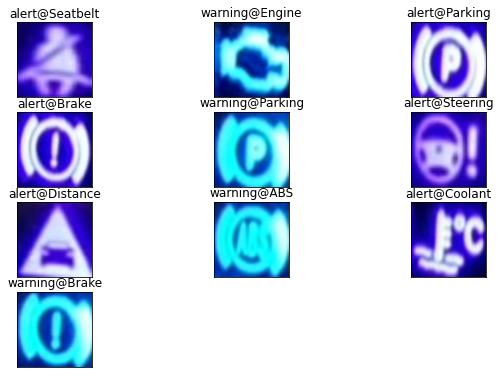

In [14]:
plot_label_images(box_images, box_labels)

In [15]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist

from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def to_feature_maps(X):
  #Convert to VGG input format
  # This is not necessary since the input is already normalized when loading
  # X_processed = preprocess_input(X)

  #include_top=False == not getting VGG16 last 3 layers
  model = VGG16(weights="imagenet", include_top=False)

  return model.predict(X)

def get_pca_reduced(X_fm, dimensions=2):
  X_fm_flat = X_fm.reshape(X_fm.shape[0], -1)
  pca = PCA(dimensions)

  X_fm_reduced = pca.fit_transform(X_fm_flat)

  return X_fm_reduced, pca


def get_clusters(X, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(X, K=2):
  # make it 2D
  X_reshaped = preprocessing.normalize(X.reshape(len(X), -1))
  X_clusters, kmeans = get_clusters(X_reshaped, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  # return X_reshaped, kmeans
  return X_reshaped, X_clusters, kmeans

def cluster_images_fm(X, K=2, cosine_distance=True):
  X_fm = to_feature_maps(X)

  # # normalize to use cosine similarity
  if cosine_distance:
    X_fm = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  X_clusters_fm, kmeans_fm = get_clusters(X_fm, K)

  # get the image ids of each cluster
  cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, range(K))

  # keep the cluster centers
  print(kmeans_fm.cluster_centers_)
  print(cluster_idx_fm)

  return X_fm, X_clusters_fm, kmeans_fm

In [21]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h * marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING/2
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("KMeans clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [16]:
idx_a_seatbelt = np.where(CLASS_NAMES.index('alert@Seatbelt') == box_labels)
idx_a_parking = np.where(CLASS_NAMES.index('alert@Parking') == box_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


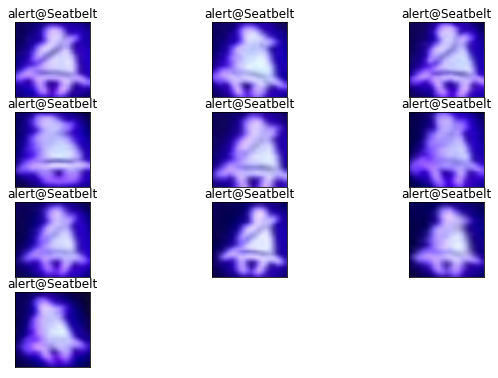

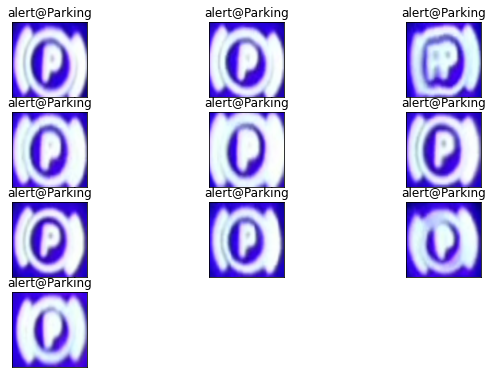

In [17]:
box_images[idx_a_seatbelt].shape

plot_label_images(box_images[idx_a_seatbelt], box_labels[idx_a_seatbelt])
plot_label_images(box_images[idx_a_parking], box_labels[idx_a_parking])

In [18]:
to_cluster = np.concatenate((box_images[idx_a_seatbelt], box_images[idx_a_parking]))
to_cluster.shape

(135, 600, 600, 3)

In [19]:
X_reshaped, X_clusters, kmeans = cluster_images(to_cluster)

[[3.45760797e-04 2.25822702e-04 8.96995134e-04 ... 3.35542552e-04
  2.04642141e-04 9.52783376e-04]
 [2.67349539e-04 1.23841473e-04 9.01415701e-04 ... 2.78258335e-04
  9.81971136e-05 9.79352094e-04]]
{0: array([ 33,  34,  35,  36,  37,  38,  39,  40,  41,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134]), 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88])}


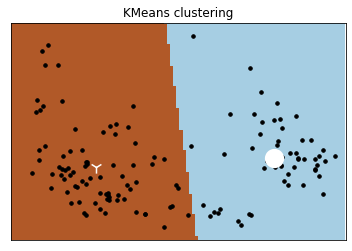

In [22]:
K = 2

# Let's do PCA for visualization
X_reduced, pca = get_pca_reduced(X_reshaped, dimensions=K)
X_clusters_reduced, kmeans_reduced = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced)

In [23]:
X_reshaped_fm, X_clusters_fm, kmeans_fm = cluster_images_fm(to_cluster)

58900480/58889256 [==============================] - 1s 0us/step
[[8.5525920e-05 0.0000000e+00 6.2615640e-05 ... 0.0000000e+00
  3.5502862e-03 0.0000000e+00]
 [3.2221211e-05 0.0000000e+00 8.4320011e-05 ... 0.0000000e+00
  3.7798276e-03 0.0000000e+00]]
{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 101,
       112, 113, 114, 134]), 1: array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 13

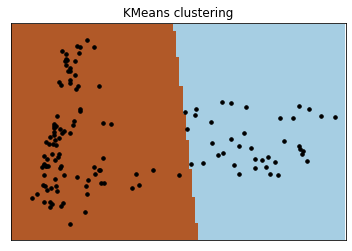

In [24]:
X_reduced_fm, pca_fm = get_pca_reduced(X_reshaped_fm, dimensions=K)
X_clusters_reduced_fm, kmeans_reduced_fm = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm)

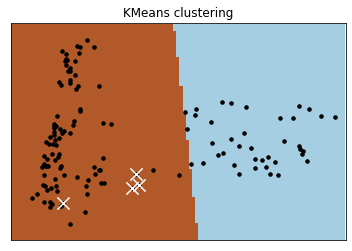

In [25]:
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm, idx=[112, 113, 114, 134])

In [30]:
def plot_scatter_clusters(X_reduced, Y):
  # plot the scatter plot along the way
  plt.figure(1)
  plt.clf()

  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap="Paired")
  plt.colorbar()


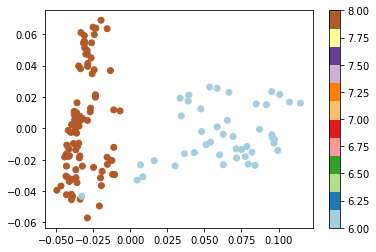

In [31]:
plot_scatter_clusters(X_reduced_fm, to_cluster_Y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


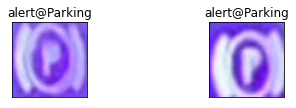

In [26]:
to_cluster_Y = np.concatenate((box_labels[idx_a_seatbelt], box_labels[idx_a_parking]))
plot_label_images(to_cluster[112:114], to_cluster_Y[112:114])


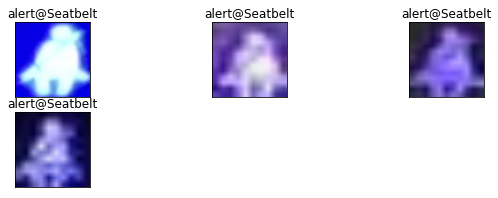

In [27]:
plot_label_images(to_cluster[85:89], to_cluster_Y[85:89])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


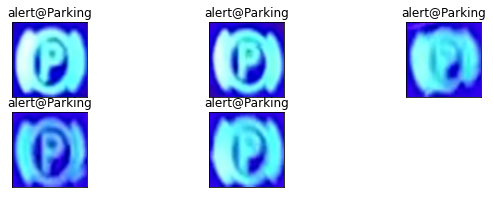

In [28]:
plot_label_images(to_cluster[120:125], to_cluster_Y[120:125])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


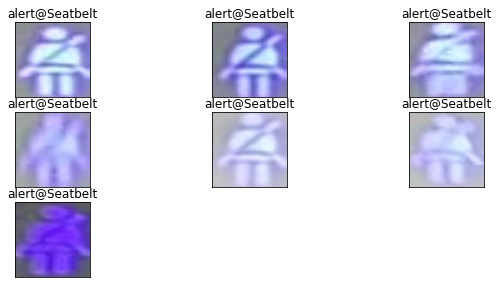

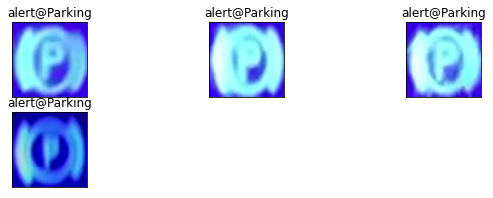

In [29]:
plot_label_images(to_cluster[33:40], to_cluster_Y[33:40])
plot_label_images(to_cluster[130:134], to_cluster_Y[130:134])


# Cluster all labels

In [34]:
K = 15
X_reshaped_fm, X_clusters_fm, kmeans_fm = cluster_images_fm(box_images, K=15)

[[ 1.7076105e-05  0.0000000e+00  8.6588334e-05 ...  0.0000000e+00
   3.5049103e-03  0.0000000e+00]
 [ 1.5638547e-04  0.0000000e+00 -2.0008883e-11 ...  0.0000000e+00
   3.4160397e-03  0.0000000e+00]
 [ 4.7482688e-05  0.0000000e+00  6.0038859e-05 ...  0.0000000e+00
   3.5597344e-03  0.0000000e+00]
 ...
 [ 4.1898264e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   2.9608426e-03  0.0000000e+00]
 [ 1.6362786e-04  0.0000000e+00 -9.0949470e-12 ...  0.0000000e+00
   3.4088637e-03  0.0000000e+00]
 [ 2.3253665e-04  0.0000000e+00 -1.4551915e-11 ...  0.0000000e+00
   3.3822933e-03  0.0000000e+00]]
{0: array([ 11,  19,  28,  37,  52,  66, 100, 114, 123, 133, 148, 160, 232,
       236, 255, 266, 279, 301, 310, 322, 332, 351, 369, 377, 419, 449,
       460, 483, 521, 535, 549, 554, 592]), 1: array([  1,  13,  25,  29,  34,  44,  47,  54,  70,  74,  76,  84,  90,
        95, 106, 107, 120, 129, 138, 141, 146, 154, 165, 172, 178, 184,
       185, 196, 201, 211, 221, 233, 238, 244, 254, 264, 268,

In [ ]:
X_reduced_fm, pca_fm = get_pca_reduced(X_reshaped_fm, dimensions=K)
X_clusters_reduced_fm, kmeans_reduced_fm = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
# plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm)

In [38]:
X_reduced_fm.shape

(623, 15)

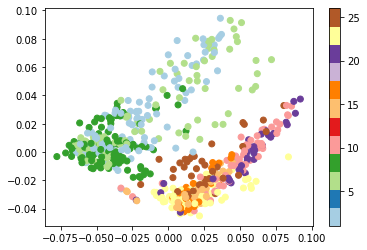

In [39]:
plot_scatter_clusters(X_reduced_fm, box_labels)

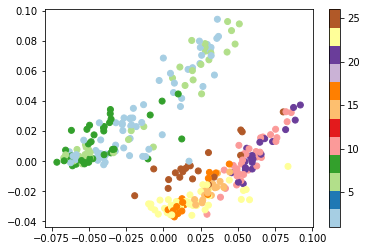

In [41]:
plot_scatter_clusters(X_reduced_fm[:300], box_labels[:300])

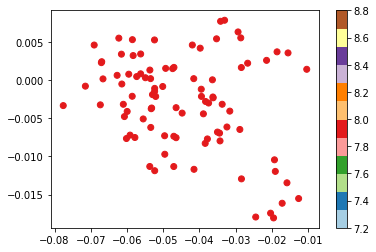

In [42]:
plot_scatter_clusters(X_reduced_fm[idx_a_seatbelt], box_labels[idx_a_seatbelt])

In [43]:
idx_a_seatbelt = np.where(CLASS_NAMES.index('alert@Seatbelt') == box_labels)
idx_a_parking = np.where(CLASS_NAMES.index('alert@Parking') == box_labels)
idx_w_engine = np.where(CLASS_NAMES.index('warning@Engine') == box_labels)

In [47]:
to_plot_X = np.concatenate((X_reduced_fm[idx_a_seatbelt], X_reduced_fm[idx_a_parking], X_reduced_fm[idx_w_engine]))
to_plot_Y = np.concatenate((box_labels[idx_a_seatbelt], box_labels[idx_a_parking], box_labels[idx_w_engine]))
to_plot_X.shape

(178, 15)

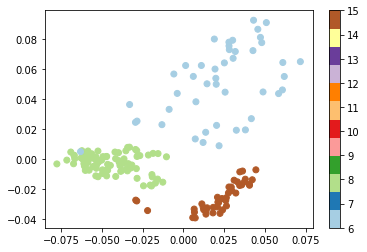

In [49]:
plot_scatter_clusters(to_plot_X, to_plot_Y)

In [116]:
def get_label_idx(labels, subset):
  idx_labels = []
  sub_labels = []
  for label in subset:
    # print(label, np.where(CLASS_NAMES.index(label) == labels)[0])
    idx = np.where(CLASS_NAMES.index(label) == labels)[0]
    idx_labels.extend(idx)

    sub_labels.extend([CLASS_NAMES.index(label) for i in range(len(idx))])

  return np.array(idx_labels), np.array(sub_labels)

box_idx_top5, box_labels_top5 = get_label_idx(box_labels, TOP5)
# box_idx_top5_n, box_labels_top5_n = get_label_idx(box_labels, TOP5, is_in=False)

print(box_idx_top5, box_labels_top5)

[  0  16  36  53  72  79  99 113 124 134 149 159 169 192 205 214 226 235
 251 260 280 287 309 323 333 341 353 364 388 397 401 409 417 422 425 426
 428 430 432 434 437 439 446 456 473 485 488 489 491 493 496 498 499 501
 504 505 506 508 512 513 515 516 518 520 522 524 526 527 536 538 550 553
 570 578 586 593 601 602 605 607 609 610 612 614 617 618 619 620 621 622
   1  29  34  47  74  84  95 107 129 138 165 178 184 201 211 221 238 268
 272 290 305 337 359 367 376 406 411 451 466 474 509 523 541 561 600 603
 604 606 608 611 613 615 616   2  21  51  62  78  92 102 116 139 164 181
 190 194 216 231 241 267 285 289 303 338 348 373 386 440 457 470 486 487
 490 492 494 495 497 500 502 503 511 514 517 519 525 528 542 581  10  24
  43  50  63  85 103 118 144 156 177 186 200 212 225 248 250 263 274 296
 313 316 327 342 361 382 394 402 410 420 445 462 480 507 529 544 551 565
 573 598  13  25  44  54  70  76  90 106 120 141 146 154 172 185 196 233
 244 254 264 276 298 315 319 329 340 356 375 387 40

In [124]:
box_labels_top5.shape

(258,)

In [125]:
box_labels.shape

(623,)

In [120]:
box_idx_top5_n = [id not in box_idx_top5 for id in range(len(box_labels))]

In [127]:
box_labels[box_idx_top5_n] = 0

In [128]:
box_labels

array([ 8, 15,  6,  0,  0,  0,  0,  0,  0,  0, 26,  0,  0, 23,  0,  0,  8,
        0,  0,  0,  0,  6,  0,  0, 26, 23,  0,  0,  0, 15,  0,  0,  0,  0,
       15,  0,  8,  0,  0,  0,  0,  0,  0, 26, 23,  0,  0, 15,  0,  0, 26,
        6,  0,  8, 23,  0,  0,  0,  0,  0,  0,  0,  6, 26,  0,  0,  0,  0,
        0,  0, 23,  0,  8,  0, 15,  0, 23,  0,  6,  8,  0,  0,  0,  0, 15,
       26,  0,  0,  0,  0, 23,  0,  6,  0,  0, 15,  0,  0,  0,  8,  0,  0,
        6, 26,  0,  0, 23, 15,  0,  0,  0,  0,  0,  8,  0,  0,  6,  0, 26,
        0, 23,  0,  0,  0,  8,  0,  0,  0,  0, 15,  0,  0,  0,  0,  8,  0,
        0,  0, 15,  6,  0, 23,  0,  0, 26,  0, 23,  0,  0,  8,  0,  0,  0,
        0, 23,  0, 26,  0,  0,  8,  0,  0,  0,  0,  6, 15,  0,  0,  0,  8,
        0,  0, 23,  0,  0,  0,  0, 26, 15,  0,  0,  6,  0,  0, 15, 23, 26,
        0,  0,  0,  6,  0,  8,  0,  6,  0, 23,  0,  0,  0, 26, 15,  0,  0,
        0,  8,  0,  0,  0,  0,  0, 15, 26,  0,  8,  0,  6,  0,  0,  0,  0,
       15,  0,  0,  0, 26

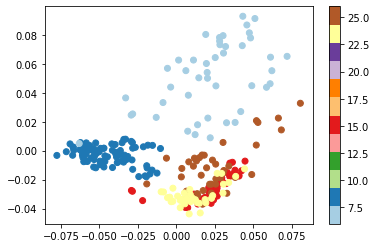

In [105]:
plot_scatter_clusters(X_reduced_fm[box_idx_top5], box_labels_top5)

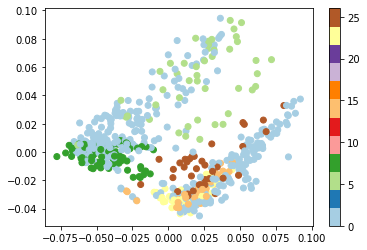

In [129]:
plot_scatter_clusters(X_reduced_fm, box_labels)

In [108]:
 [(label, CLASS_NAMES.index(label)) for label in TOP5]

[('alert@Seatbelt', 8),
 ('warning@Engine', 15),
 ('alert@Parking', 6),
 ('warning@Tire', 26),
 ('warning@StabilityOn', 23)]

In [109]:
box_idx_top5

array([  0,  16,  36,  53,  72,  79,  99, 113, 124, 134, 149, 159, 169,
       192, 205, 214, 226, 235, 251, 260, 280, 287, 309, 323, 333, 341,
       353, 364, 388, 397, 401, 409, 417, 422, 425, 426, 428, 430, 432,
       434, 437, 439, 446, 456, 473, 485, 488, 489, 491, 493, 496, 498,
       499, 501, 504, 505, 506, 508, 512, 513, 515, 516, 518, 520, 522,
       524, 526, 527, 536, 538, 550, 553, 570, 578, 586, 593, 601, 602,
       605, 607, 609, 610, 612, 614, 617, 618, 619, 620, 621, 622,   1,
        29,  34,  47,  74,  84,  95, 107, 129, 138, 165, 178, 184, 201,
       211, 221, 238, 268, 272, 290, 305, 337, 359, 367, 376, 406, 411,
       451, 466, 474, 509, 523, 541, 561, 600, 603, 604, 606, 608, 611,
       613, 615, 616,   2,  21,  51,  62,  78,  92, 102, 116, 139, 164,
       181, 190, 194, 216, 231, 241, 267, 285, 289, 303, 338, 348, 373,
       386, 440, 457, 470, 486, 487, 490, 492, 494, 495, 497, 500, 502,
       503, 511, 514, 517, 519, 525, 528, 542, 581,  10,  24,  4